The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 随机梯度下降
:label:`sec_sgd`

但是，在前面的章节中，我们一直在训练过程中使用随机梯度下降，但没有解释它为什么起作用。为了澄清这一点，我们刚在 :numref:`sec_gd` 中描述了梯度下降的基本原则。在本节中，我们继续讨论
*更详细地说明随机梯度下降 *。


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l


## 随机渐变更新

在深度学习中，目标函数通常是训练数据集中每个示例的损失函数的平均值。给定 $n$ 个示例的训练数据集，我们假设 $f_i(\mathbf{x})$ 是与指数 $i$ 的训练示例相比的损失函数，其中 $\mathbf{x}$ 是参数矢量。然后我们到达目标功能 

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

$\mathbf{x}$ 的目标函数的梯度计算为 

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

如果使用梯度下降，则每次独立变量迭代的计算成本为 $\mathcal{O}(n)$，随 $n$ 线性增长。因此，当训练数据集较大时，每次迭代的梯度下降成本将更高。 

随机梯度下降 (SGD) 可降低每次迭代时的计算成本。在随机梯度下降的每次迭代中，我们随机统一采样一个指数 $i\in\{1,\ldots, n\}$ 以获取数据示例，并计算渐变 $\nabla f_i(\mathbf{x})$ 以更新 $\mathbf{x}$： 

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中 $\eta$ 是学习率。我们可以看到，每次迭代的计算成本从梯度下降的 $\mathcal{O}(n)$ 降至常数 $\mathcal{O}(1)$。此外，我们要强调，随机梯度 $\nabla f_i(\mathbf{x})$ 是对完整梯度 $\nabla f(\mathbf{x})$ 的公正估计，因为 

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

这意味着，平均而言，随机梯度是对梯度的良好估计值。 

现在，我们将把它与梯度下降进行比较，方法是向渐变添平均值 0 和方差 1 的随机噪声，以模拟随机渐变下降。


In [2]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: 0.300851, x2: -0.225463


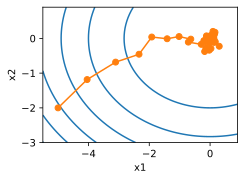

In [4]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比我们在 :numref:`sec_gd` 中观察到的梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最低值，我们仍然受到通过 $\eta \nabla f_i(\mathbf{x})$ 的瞬间梯度所注入的不确定性的影响。即使经过 50 个步骤，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会改善（我们鼓励你尝试更多的步骤来确认这一点）。这给我们留下了唯一的选择：改变学习率 $\eta$。但是，如果我们选择太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择太大，我们将无法获得上文所述的好解决方案。解决这些相互冲突的目标的唯一方法是随着优化的进展动态 * 降低学习率 *。 

这也是在 `sgd` 步长函数中添加学习率函数 `lr` 的原因。在上面的示例中，任何学习率调度功能都处于休眠状态，因为我们将关联的 `lr` 函数设置为恒定。 

## 动态学习率

用时间相关的学习率 $\eta(t)$ 取代 $\eta$ 增加了控制优化算法收敛的复杂性。特别是，我们需要弄清 $\eta$ 应该有多快衰减。如果速度太快，我们将过早停止优化。如果我们减少速度太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整 $\eta$ 时使用的一些基本策略（稍后我们将讨论更高级的策略）： 

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

在第一个 * 分段常数 * 场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过 * 指数衰减 * 来更积极地减少它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是 * 多项式衰变 * 与 $\alpha = 0.5$。在凸优化的情况下，有许多证据表明这种速率表现良好。 

让我们看看指数衰减在实践中是什么样子。


epoch 1000, x1: -0.767794, x2: -0.033320


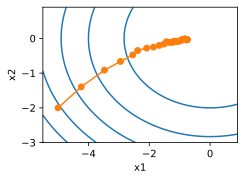

In [5]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的差异大大减少。但是，这是以未能融合到最佳解决方案 $\mathbf{x} = (0, 0)$ 为代价的。即使经过 1000 个迭代步骤，我们仍然离最佳解决方案很远。事实上，该算法根本无法收敛。另一方面，如果我们使用多项式衰减，其中学习率下降，步数的逆平方根，那么仅在 50 个步骤之后，收敛就会更好。


epoch 50, x1: 0.002664, x2: 0.003861


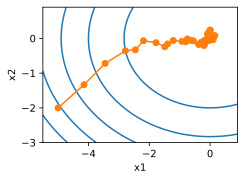

In [6]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

关于如何设置学习率，还有更多的选择。例如，我们可以从较小的利率开始，然后迅速上涨，然后再次降低，尽管速度更慢。我们甚至可以在较小和更大的学习率之间交替。这样的时间表有各种各样。现在，让我们专注于可以进行全面理论分析的学习率时间表，即凸环境下的学习率。对于一般的非凸问题，很难获得有意义的收敛保证，因为总的来说，最大限度地减少非线性非凸问题是 NP 困难的。有关调查，例如，请参阅 Tibshirani 2015 年的优秀 [讲义笔记]（https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf）。 

## 凸目标的收敛性分析

以下对凸目标函数的随机梯度下降的收敛性分析是可选的，主要用于传达对问题的更多直觉。我们只限于最简单的证明之一 :cite:`Nesterov.Vial.2000`。存在着明显更先进的证明技术，例如，当客观功能表现特别好时。 

假设所有 $\boldsymbol{\xi}$ 的目标函数 $f(\boldsymbol{\xi}, \mathbf{x})$ 在 $\mathbf{x}$ 中都是凸的。更具体地说，我们考虑随机梯度下降更新： 

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),$$

其中 $f(\boldsymbol{\xi}_t, \mathbf{x})$ 是培训实例 $f(\boldsymbol{\xi}_t, \mathbf{x})$ 的客观功能：$\boldsymbol{\xi}_t$ 从第 $t$ 步的某些分布中摘取，$\mathbf{x}$ 是模型参数。表示通过 

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]$$

预期风险和 $R^*$ 相对于 $\mathbf{x}$ 的最低风险。最后让 $\mathbf{x}^*$ 成为最小化器（我们假设它存在于定义 $\mathbf{x}$ 的域中）。在这种情况下，我们可以跟踪当前参数 $\mathbf{x}_t$ 当时 $\mathbf{x}_t$ 和风险最小化器 $\mathbf{x}^*$ 之间的距离，看看它是否随着时间的推移而改善： 

$$\begin{aligned}    &\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \\ =& \|\mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}) - \mathbf{x}^*\|^2 \\    =& \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 - 2 \eta_t    \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle.   \end{aligned}$$
:eqlabel:`eq_sgd-xt+1-xstar`

我们假设 $L_2$ 随机梯度 $\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$ 的标准受到一定的 $L$ 的限制，因此我们有这个 

$$\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2.$$
:eqlabel:`eq_sgd-L`

我们最感兴趣的是 $\mathbf{x}_t$ 和 $\mathbf{x}^*$ 之间的距离如何变化 * 预期 *。事实上，对于任何具体的步骤序列，距离可能会增加，这取决于我们遇到的 $\boldsymbol{\xi}_t$。因此我们需要绑定点积。因为对于任何凸函数 $f$，它认为所有 $\mathbf{x}$ 和 $\mathbf{y}$ 的 $f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle$ 和 $\mathbf{y}$，按凸度我们有 

$$f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.$$
:eqlabel:`eq_sgd-f-xi-xstar`

将不等式 :eqref:`eq_sgd-L` 和 :eqref:`eq_sgd-f-xi-xstar` 插入 :eqref:`eq_sgd-xt+1-xstar` 我们在时间 $t+1$ 时获得参数之间距离的边界，如下所示： 

$$\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.$$
:eqlabel:`eqref_sgd-xt-diff`

这意味着，只要当前亏损和最佳损失之间的差异超过 $\eta_t L^2/2$，我们就会取得进展。由于这种差异必然会收敛到零，因此学习率 $\eta_t$ 也需要 * 消失 *。 

接下来，我们的预期超过 :eqref:`eqref_sgd-xt-diff`。这会产生 

$$E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.$$

最后一步是对 $t \in \{1, \ldots, T\}$ 的不平等现象进行总结。自从总和望远镜以及通过掉低期我们获得的 

$$\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$
:eqlabel:`eq_sgd-x1-xstar`

请注意，我们利用了 $\mathbf{x}_1$ 给出了，因此预期可以下降。最后定义 

$$\bar{\mathbf{x}} \stackrel{\mathrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.$$

自 

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)],$$

根据延森的不平等性（设定为 $i=t$，$i=t$，$\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$）和 $R$ 的凸度为 $R$，因此， 

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].$$

将其插入不平等性 :eqref:`eq_sgd-x1-xstar` 收益了限制 

$$
\left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},
$$

其中 $r^2 \stackrel{\mathrm{def}}{=} \|\mathbf{x}_1 - \mathbf{x}^*\|^2$ 受初始选择参数与最终结果之间的距离的约束。简而言之，收敛速度取决于随机梯度标准的限制方式（$L$）以及初始参数值与最优性（$r$）的距离（$r$）。请注意，约束是按 $\bar{\mathbf{x}}$ 而不是 $\mathbf{x}_T$ 而不是 $\mathbf{x}_T$。情况就是这样，因为 $\bar{\mathbf{x}}$ 是优化路径的平滑版本。只要知道 $r, L$ 和 $T$，我们就可以选择学习率 $\eta = r/(L \sqrt{T})$。这个收益率为上限 $rL/\sqrt{T}$。也就是说，我们将汇率 $\mathcal{O}(1/\sqrt{T})$ 收敛到最佳解决方案。 

## 随机梯度和有限样本

到目前为止，在谈论随机梯度下降时，我们玩得有点快而松散。我们假设我们从 $x_i$ 中绘制实例 $x_i$，通常使用来自某些发行版 $p(x, y)$ 的标签 $y_i$，我们用它来以某种方式更新模型参数。特别是，对于有限的样本数量，我们只是认为，某些函数 $\delta_{x_i}$ 和 $\delta_{y_i}$ 的离散分布 $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$ 和 $\delta_{y_i}$ 允许我们在其上执行随机梯度下降。 

但是，这不是我们真正做的。在当前部分的玩具示例中，我们只是将噪音添加到其他非随机梯度上，也就是说，我们假装了对 $(x_i, y_i)$。事实证明，这是合理的（请参阅练习进行详细讨论）。更令人不安的是，在以前的所有讨论中，我们显然没有这样做。相反，我们遍历了所有实例 * 恰好一次 *。要了解为什么这更可取，请考虑反之，即我们从离散分布 * 中抽取 $n$ 个观测值 * 并带替换 *。随机选择一个元素 $i$ 的概率是 $1/n$。因此选择它 * 至少 * 一次就是 

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.$$

类似的推理表明，挑选一些样本（即训练示例）* 恰好一次 * 的概率是由 

$${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.$$

这导致与采样 * 不替换 * 相比，差异增加并降低数据效率。因此，在实践中我们执行后者（这是本书中的默认选择）。最后一点注意，重复穿过训练数据集会以 * 不同的 * 随机顺序遍历它。 

## 摘要

* 对于凸出的问题，我们可以证明，对于广泛的学习率选择，随机梯度下降将收敛到最佳解决方案。
* 对于深度学习而言，情况通常并非如此。但是，对凸问题的分析使我们能够深入了解如何进行优化，即逐步降低学习率，尽管不是太快。
* 如果学习率太小或太大，就会出现问题。实际上，通常只有经过多次实验后才能找到合适的学习率。
* 当训练数据集中有更多示例时，计算渐变下降的每个迭代的成本更高，因此在这些情况下，首选随机梯度下降。
* 随机梯度下降的最佳性保证在非凸情况下一般不可用，因为需要检查的局部最小值数可能是指数级的。

## 练习

1. 尝试不同的学习速率计划以实现随机梯度下降和不同迭代次数。特别是，根据迭代次数的函数来绘制与最佳解 $(0, 0)$ 的距离。
1. 证明对于函数 $f(x_1, x_2) = x_1^2 + 2 x_2^2$ 而言，向梯度添加正常噪声等同于最小化损耗函数 $f(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$，其中 $\mathbf{x}$ 是从正态分布中提取的。
1. 比较随机梯度下降的收敛性，当您从 $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ 采样时使用替换方法进行采样时以及在不替换的情况下进行样品时
1. 如果某些渐变（或者更确切地说与之相关的某些坐标）始终比所有其他渐变都大，你将如何更改随机渐变下降求解器？
1. 假设是 $f(x) = x^2 (1 + \sin x)$。$f$ 有多少本地最小值？你能改变 $f$ 以尽量减少它需要评估所有本地最小值的方式吗？


[Discussions](https://discuss.d2l.ai/t/3838)
